In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

/var/folders/k0/63_q54b92xq0jn878sr6yb3w80rd_w/T/ipykernel_10649/2903869872.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [42]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

# '''os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use 
#    or we can say this method generates a string containing random characters.'''
# https://www.geeksforgeeks.org/python-os-urandom-method/ 

In [43]:
salt_generator()

'pKyrk4p/jSU='

In [4]:
# Делим на 2 равные группы 
def groups_splitter(df, columns, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [5]:
from scipy.stats import norm

In [6]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [39]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

In [40]:
interactions.head(5).append(interactions.tail())

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0



## Переходим к валидации критерия
- оценка распределения p_value
- оценка мощности
- корректности

**Распределения p_value** при корректном подборе пары метрика + критерий -  равномерное распределение

**Достоверность (Корректность)** - вероятность того, что найдет различие, когда его нет

$$significance = Pr(\text{reject }H_0 | H_0 \text{ is true})$$

**Мощность** - вероятность того, что критерий найдет различие в случае, когда оно есть

$$power = Pr(\text{reject }H_0 | H_1 \text{ is true})$$


In [7]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [48]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

## Валидируем корректноcть (significance)

Моделируем AA-test: прогоняем бутстрап критерий, не добавляя эффект к группе В. Хотим, чтобы критерий НЕ нашел различий в выборках. Если точнее, то нашел не более чем  $\alpha$ случаях.

In [83]:
correctness = []
values = []

for i in tqdm(range(100)): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week1.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|██████████| 100/100 [07:15<00:00,  4.36s/it]

significance: 5.0%


# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага 

СОВЕТ: Т.к бутстрэп считается долго, то для дз отлаживаем код на малом количестве итераций, а результаты уже показываем на 1000+

## ДЗ-1.1

In [9]:
interactions = pd.read_csv('interactions.csv')

In [10]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

In [11]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [12]:
week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [13]:
week2.head(3)

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,33776


In [14]:
max(week2['total_dur'])

9731801

In [15]:
###Правило 3х сигм, убираем выбросы

In [16]:
print(week2.shape)
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]
print(week2.shape)

(279129, 2)
(275616, 2)


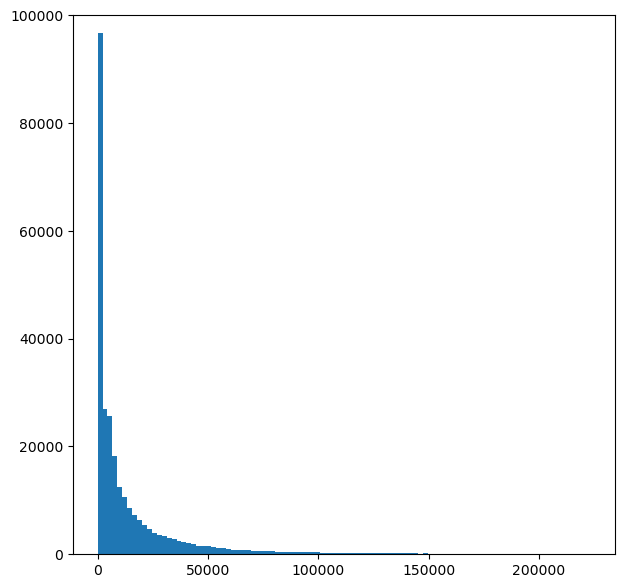

In [17]:
week2['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 100_000])
plt.grid(False)

### ДЗ 1.1.1

In [18]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|█████████████████████████████████████| 1000/1000 [2:00:18<00:00,  7.22s/it]

significance: 5.3%


Корректность на бутстрапе 5.3%, в принципе неплохо для нашего уровня значимости. Если интерпретировать, то в с веротяностью 0.05 у нас сработает ошибка первого рода(отклоняем верную H_0).

### ДЗ 1.1.2

In [19]:
correctness_1_persent = []
correctness_3_persent = []
correctness_5_persent = []

values_1_persent = []
values_3_persent = []
values_5_persent = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    # умножим значения группы B на 1,3,5 процентов соответственно
    # и округлим, тк изначально у нас время целочисленное
    vec_b_1 = np.round(vec_b*1.01).astype(int)
    vec_b_3 = np.round(vec_b*1.03).astype(int)
    vec_b_5 = np.round(vec_b*1.05).astype(int)
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_1_mean = calc_bootstrap_mean(vec_b_1, size=1000)
    sample_b_3_mean = calc_bootstrap_mean(vec_b_3, size=1000)
    sample_b_5_mean = calc_bootstrap_mean(vec_b_5, size=1000)
    
    values_1_persent.append(sample_a_mean - sample_b_1_mean)
    values_3_persent.append(sample_a_mean - sample_b_3_mean)
    values_5_persent.append(sample_a_mean - sample_b_5_mean)
    
    left_side_1_p, right_side_1_p = np.percentile(sample_a_mean - sample_b_1_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    left_side_3_p, right_side_3_p = np.percentile(sample_a_mean - sample_b_3_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    
    left_side_5_p, right_side_5_p = np.percentile(sample_a_mean - sample_b_5_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    
    correctness_1_persent.append(not left_side_1_p <= 0 <= right_side_1_p)
    correctness_3_persent.append(not left_side_3_p <= 0 <= right_side_3_p)
    correctness_5_persent.append(not left_side_5_p <= 0 <= right_side_5_p)
    
    test_correctness_1_persent = collections.Counter(correctness_1_persent)
    test_correctness_3_persent = collections.Counter(correctness_3_persent)
    test_correctness_5_persent = collections.Counter(correctness_5_persent)
    
print(f'power(1%) : {test_correctness_1_persent[1]/(test_correctness_1_persent[1] + test_correctness_1_persent[0])*100}%')
print(f'power(3%) : {test_correctness_3_persent[1]/(test_correctness_3_persent[1] + test_correctness_3_persent[0])*100}%')
print(f'power(5%) : {test_correctness_5_persent[1]/(test_correctness_5_persent[1] + test_correctness_5_persent[0])*100}%')

100%|█████████████████████████████████████| 1000/1000 [3:47:14<00:00, 13.63s/it]

power(1%) : 36.6%
power(3%) : 99.2%
power(5%) : 100.0%


Полученная мощность равна 33%. Интерпретация: С 33% вероятностью мы найдем отличия между группами A и B

### ДЗ 1.1.3

Мы не можем использовать стандартную формулу MDE, тк вектор значений не распределен нормально. В примере на семинаре, выборка генерируется случайно. Предлагаю воспользоваться бутстрапом для генерации нормальнораспределенной выборки по ЦПТ. Считаю, что 100_000 средних значений, достаточно, чтобы говорить о больших числах.

In [15]:
result = []
for i in tqdm(range(100)):
    
    sample_mean = calc_bootstrap_mean(week2['total_dur'], size=1000)
    result.extend(sample_mean)

100%|█████████████████████████████████████████| 100/100 [11:41<00:00,  7.01s/it]


Получили массив длинной 100_000, каждое значение это среднее рандомной выборки длиной в 1000 значений.

In [83]:
len(result)

100000

In [85]:
max(result)

16442.210426825728

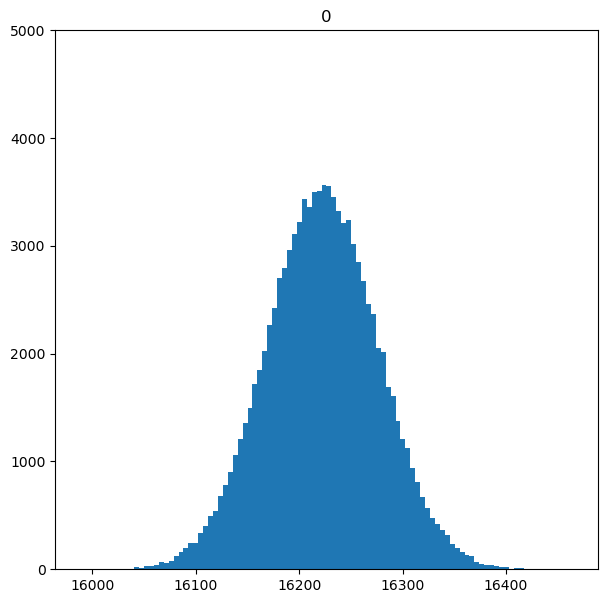

In [16]:
pd.DataFrame(result).hist(bins=100, figsize=(7,7))
plt.ylim([0, 5_000])
plt.grid(False)

Считаю, что данное распределение можно считать нормальным или около нормальным.

In [17]:
result = pd.DataFrame(result)

In [47]:
get_mde(week2['total_dur'], alpha=0.045, beta=0.8)

0.3870184096123142

Немного странно, что мы берем параметры альфа и бета для не нормального распределения и подставляем их в mde с нормальным распределением.

In [29]:
get_mde(result, alpha=0.045, beta=0.33)

0    0.002576
dtype: float64

Подсмотрено в Дискорде

In [20]:
powers = [0.366, 0.992]
effects = [1.01, 1.03]

In [25]:
k = (powers[1] - powers[0]) / (effects[1] - effects[0])
b = powers[1] - effects[1] * k

power_needed = 0.8
mde = (power_needed - b) / k

In [26]:
mde

1.0238658146964856

## ДЗ 1.2

### ДЗ 1.2.1

In [28]:
res = week2.copy()

### ДЗ 1.2.2

Зануляем все значения меньше 500.

<Axes: >

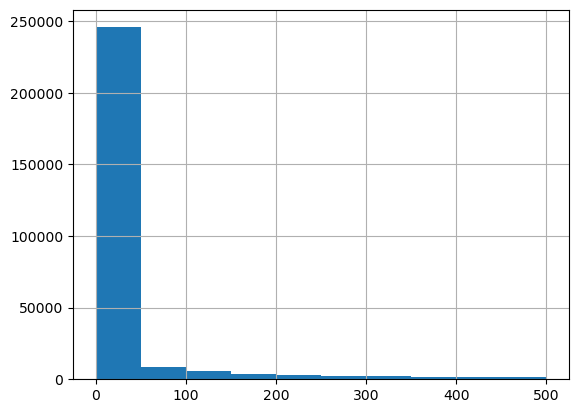

In [29]:
res['total_dur'].where(res['total_dur'] <= 500, 0, inplace=True)
res['total_dur'].hist(bins=10)

### ДЗ 1.2.3

Разбиваем на две группы

In [30]:
res_group = groups_splitter(res, columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')
res_group.head()

,user_id,total_dur,group
0,1,0,B
1,1000,0,B
2,1000000,0,B
3,1000001,52,B
4,1000003,0,A


### ДЗ 1.2.4

Находим 10% "самых смотрящих" из группы B и добавляем эффект в 2.5%

In [31]:
np.round(len(res_group[res_group['group']=='B'])*0.9)

123476.0

In [36]:
indexes = list(res_group[res_group['group']=='B']["total_dur"].sort_values()[123476:].index)

In [37]:
for index in indexes:
     res_group["total_dur"][index] = np.round(res_group["total_dur"][index]*1.025).astype(int)

/var/folders/k0/63_q54b92xq0jn878sr6yb3w80rd_w/T/ipykernel_10649/3453993183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_group["total_dur"][index] = np.round(res_group["total_dur"][index]*1.025).astype(int)


### ДЗ 1.2.5

Используем критерий Манна — Уитни для оценки различий между двумя выборками 

In [39]:
from scipy.stats import mannwhitneyu

# проверим, как работает код критерия
u, p = mannwhitneyu(res_group[res_group['group'] == 'A']['total_dur'].values,
                    res_group[res_group['group'] == 'B']['total_dur'].values)

print(f"p_value = {p}")

p_value = 0.21357563451472905


Тк p_value превышает значение 0.05, мы отвергаем H_0, что выборки не различны между собой.

Также можно сравнить средние

In [51]:
vec_a = res_group[(res_group['group'] == 'A')]['total_dur']
vec_b = res_group[(res_group['group'] == 'B')]['total_dur']

#bootstrap
sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
values.append(sample_a_mean - sample_b_mean)

left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
p_value = get_p_value(values)
print(f"p-value = {p_value}")

p-value = 0.9856430707876371


H_0 - отвергается, тк средние значения групп A и B, могут иметь статистические отличия

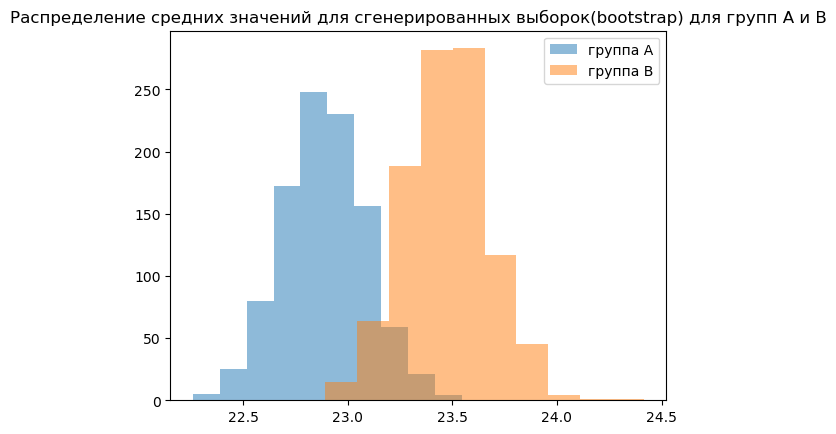

In [56]:
plt.hist(sample_a_mean, alpha=0.5, label="группа A");
plt.hist(sample_b_mean, alpha=0.5, label="группа B")
plt.legend()
plt.title("Распределение средних значений для сгенерированных выборок(bootstrap) для групп А и B");